<a href="https://colab.research.google.com/github/arjasc5231/Lingometer/blob/speaker_verification/speaker_verificaiton/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import json
import shutil
import random
import pickle

#import import_ipynb
#from constants import CHECKPOINTS_DIR, NUM_FBANK, HOP_LENGTH # 잠깐 에러 피하려고 주석처리. 나중에 풀기

In [ ]:
def pcm2npy(file_path):
    # https://kaen2891.tistory.com/107
    with open(file_path, 'rb') as opened_pcm_file:
        buf = opened_pcm_file.read()
        pcm = np.frombuffer(buf, dtype = 'int16')
        wav = librosa.util.buf_to_float(pcm, 2)
    return wav

In [ ]:
def trim_silence(wav):
    energy = np.abs(wav)
    silence_threshold = np.percentile(energy, 95)
    offsets = np.where(energy > silence_threshold)[0]
    # librosa.trim같은 방법도 있음. https://malaya-speech.readthedocs.io/en/latest/remove-silent-vad.html
    wav_trimed = wav[offsets[0]:offsets[-1]]
    return wav_trimed

In [ ]:
def npy2spec(wav): # return: [time][freq][ch]
    # TODO : 스펙트로그램 파라미터를 아두이노에서 사용할 c++ library와 같게 맞춰야한다.
    spec = librosa.power_to_db(librosa.feature.melspectrogram(y=wav, sr=16000, n_fft=NUM_FBANK, hop_length=HOP_LENGTH)) # 아마도 n_mels=128이 default값
    """
    delta1 = librosa.feature.delta(data=mel, width=5)
    delta2 = librosa.feature.delta(data=delta1, width=5)
    stack = np.dstack((mel,delta1,delta2)) #-> (128,t,3)
    """
    spec = spec.T
    spec_normalized = normalize_frames(spec)
    spec_normalized = np.expand_dims(spec_normalized, axis=-1)
    return spec_normalized

def normalize_frames(m, epsilon=1e-12): # from DeepSpeaker's code
    return [(v - np.mean(v)) / max(np.std(v), epsilon) for v in m]

In [ ]:
# 음성 하나를 spectrogram으로 변환
def convert(file_path):
    wav = pcm2npy(file_path)
    wav = trim_silence(wav)
    spec = npy2spec(wav)
    return spec

In [ ]:
def convert_all(pcm_dir, json_dir, cache_dir, already_converted_json_name=0):
    for json_filename in os.listdir(json_dir):
        if json_filename<=already_converted_json_name: continue
        pcm_dirname = json_filename[:-5]
        with open(json_dir+'/'+json_filename, "r", encoding="utf-8") as json_file: info = json.load(json_file)
        for utt_info in info['document'][0]["utterance"]:
            utt_id = utt_info['id']
            spk_id = utt_info['speaker_id']
            pcm_filepath = pcm_dir+'/'+pcm_dirname+'/'+utt_id+'.pcm'
            try: spec = convert(pcm_filepath)
            except: print('worng filename:',pcm_filepath); continue
            
            spk_dir = cache_dir+'/'+spk_id
            if not os.path.exists(spk_dir): os.makedirs(spk_dir)
            npy_filepath = spk_dir+'/'+utt_id+".npy"
            np.save(npy_filepath, spec)

In [ ]:
def validation_split(cache_dir):
    # speaker dir list
    speakers = os.listdir(cache_dir)
    
    # split validation speaker
    random.shuffle(speakers)
    split_idx = len(speakers)//10
    speakers_traintest = speakers[split_idx:]
    speakers_validation = speakers[:split_idx]
    
    # make dir for save
    traintest_dir = cache_dir+'/traintest'
    validation_dir = cache_dir+'/validation'
    os.makedirs(traintest_dir)
    os.makedirs(validation_dir)
    
    # move to saving dir
    for speaker in speakers_traintest: shutil.move(cache_dir+'/'+speaker, traintest_dir)
    for speaker in speakers_validation: shutil.move(cache_dir+'/'+speaker, validation_dir)

13248


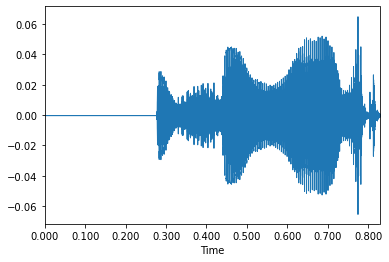

In [ ]:
audio = pcm2npy('./samples/pcm/SDRW2000000001/SDRW2000000001.1.1.187.pcm')
print(len(audio))
librosa.display.waveplot(audio, sr=16000)
ipd.Audio(audio, rate = 16000)

8478


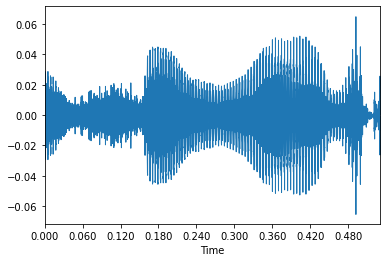

In [ ]:
audio_voice_only = trim_silence(audio)
print(len(audio_voice_only))
librosa.display.waveplot(audio_voice_only, sr=16000)
ipd.Audio(audio_voice_only, rate = 16000)

(67, 128, 1)


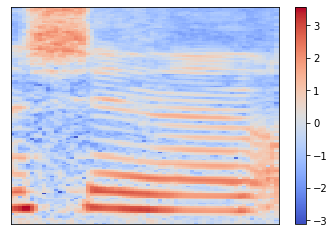

In [ ]:
spec = convert('./samples/pcm/SDRW2000000001/SDRW2000000001.1.1.187.pcm')
print(spec.shape)
plt.figure()
display.specshow(spec[:,:,0].T)
plt.colorbar()

In [ ]:
convert_all('C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/pcm','C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/json','C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/npy')
"""
실행해보니 파일 두개 문제있었음
worng filename: C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/pcm/SDRW2000000144/SDRW2000000144.1.1.114.pcm
worng filename: C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/pcm/SDRW2000000176/SDRW2000000176.1.1.502.pcm

"""

C:\Users\LeeJunghun\AppData\Local\Temp\ipykernel_9916\1497241030.py:6: FutureWarning: Pass n_bytes=2 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  wav = librosa.util.buf_to_float(pcm, 2)


worng filename: C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/pcm/SDRW2000000144/SDRW2000000144.1.1.114.pcm
worng filename: C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/pcm/SDRW2000000176/SDRW2000000176.1.1.502.pcm


In [ ]:
validation_split('C:/Users/LeeJunghun/Desktop/lingometer/data/NIKL_DIALOGUE_2020_PCM_v1.2_part1/NIKL_DIALOGUE_2020_PCM_v1.2_part1/npy')
# 화자 총 716명. 71명이 val로 이동

NameError: name 'validatoin_dir' is not defined

In [ ]:
# 이하 colab에서 dataset 제대로 만들어졌는지 확인해본 코드

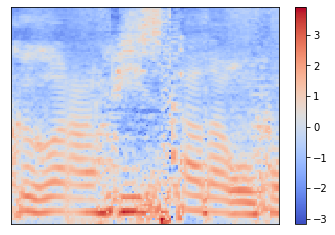

In [ ]:
with open('/content/drive/MyDrive/team_malmungchi/colab/speaker_verification/data/naive_batcher/167_300_128_512.npy',"rb") as f:
  X_train, X_test, Y_train, Y_test = pickle.load(f)

spec = X_train[0]
plt.figure()
display.specshow(spec[:,:,0].T)
plt.colorbar()

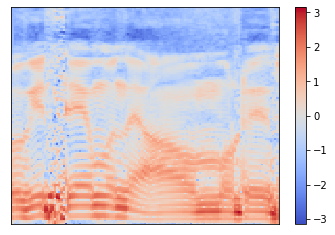

In [ ]:
spec = X_train[4]
plt.figure()
display.specshow(spec[:,:,0].T)
plt.colorbar()